<h1 style="text-align:center;">Task 7: Root System Architecture (RSA) Extraction</h1>

## Overview

---

Root system architecture (RSA) analysis is crucial for understanding plant development and health. While a root mask provides basic pixel-level segmentation (1 for roots, 0 for background), RSA extraction reveals the complex branching structure and relationships between different root components.

This task focuses on:
1. Converting binary root masks into detailed RSA representations
2. Identifying and classifying different root types (primary, secondary, etc.)
3. Detecting root tips and branch points
4. Measuring key morphological features like primary root length

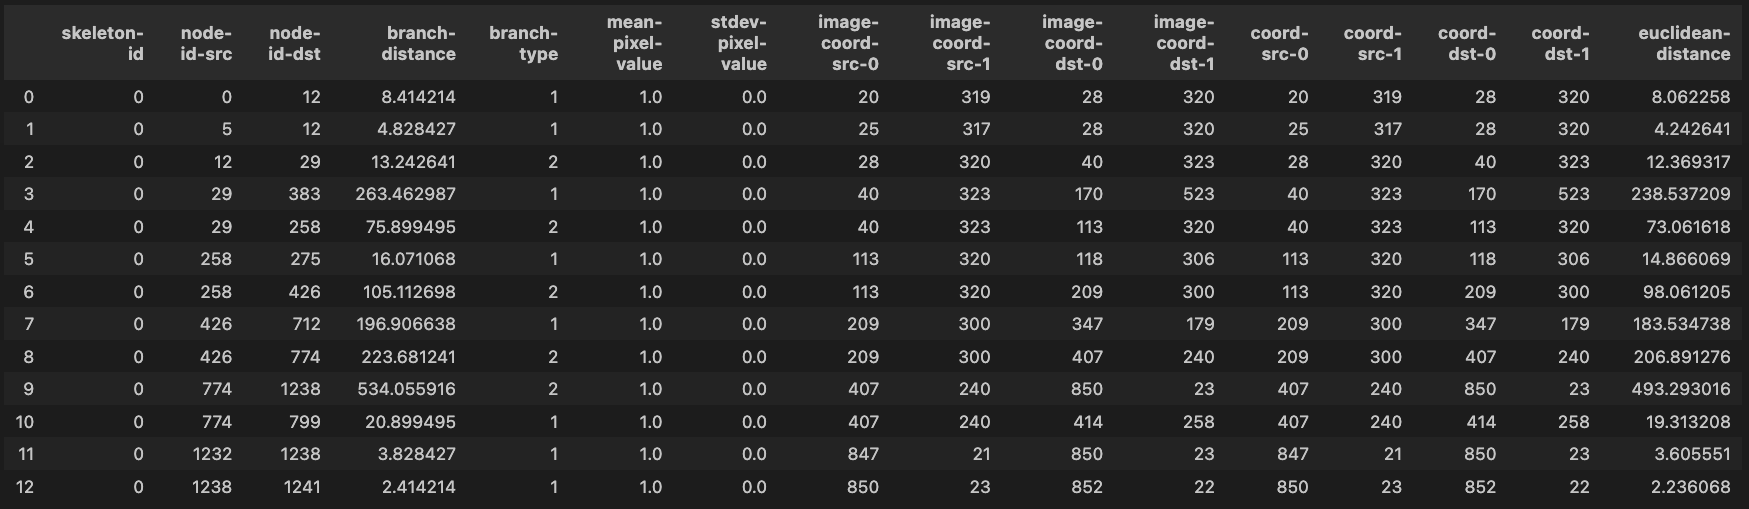

Figure 7.1: Detailed RSA visualization of Plant 0, showing the complex root system with 13 distinct branches. The visualization includes branch start/end points, hierarchical relationships, and other structural characteristics essential for analysis.

A key deliverable is accurate measurement of primary root length and identification of root tip coordinates. These coordinates are particularly valuable for automated robotic systems that perform targeted operations like root tip inoculation, though root tip detection is not required for Tasks 7 and 8.

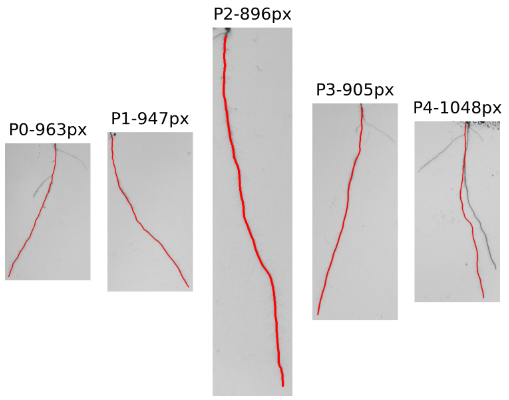

Figure 7.2: Primary root detection results. Red lines highlight the identified primary roots, with computed length measurements shown above each sample image.

<br>

## Initial Setup

---

In [1]:
# Import the libraries
import cv2
import glob
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from skimage.morphology import skeletonize
from skimage.graph import route_through_array
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional

In [2]:
# Add the path to the task5 directory and add it to Python path
task5_dir = os.path.join(os.getcwd(), '..', 'task5')
import sys
sys.path.append(task5_dir)

# Import inference.py module from task5
import inference

<br>

## Load the Model

---

In this section, we will create a U-Net model with a patch size of 960x960 pixels and load pre-trained weights from a previously saved model file ('best_model.weights.h5') located in the task5 directory.

In [3]:
# Patch size
patch_size = 960

# Build U-Net
model = inference.unet_model(
    IMG_HEIGHT=patch_size,
    IMG_WIDTH=patch_size,
    IMG_CHANNELS=1
)

# Load the weight if it exists
# model.load_weights(f'soheil_6989490_unet_model_{patch_size}px.h5')
model.load_weights('./../task5/best_model.weights.h5')

e:\University\2024-25b-fai2-adsai-SoheilMohammadpour231754\datalab_tasks\task7\..\task5\inference.py:200: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(
c:\Users\Soheil\.conda\envs\cv_rl_pipeline\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 272 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<br>

## Root System Architecture

---

In this section, we will analyze root system architecture from binary masks using a comprehensive class called RootArchitectureAnalyzer that segments individual roots, extracts their skeletons, finds primary root paths, and generates detailed metrics and visualizations for root analysis.

In [4]:
# Import the local module
from RAA import *

Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


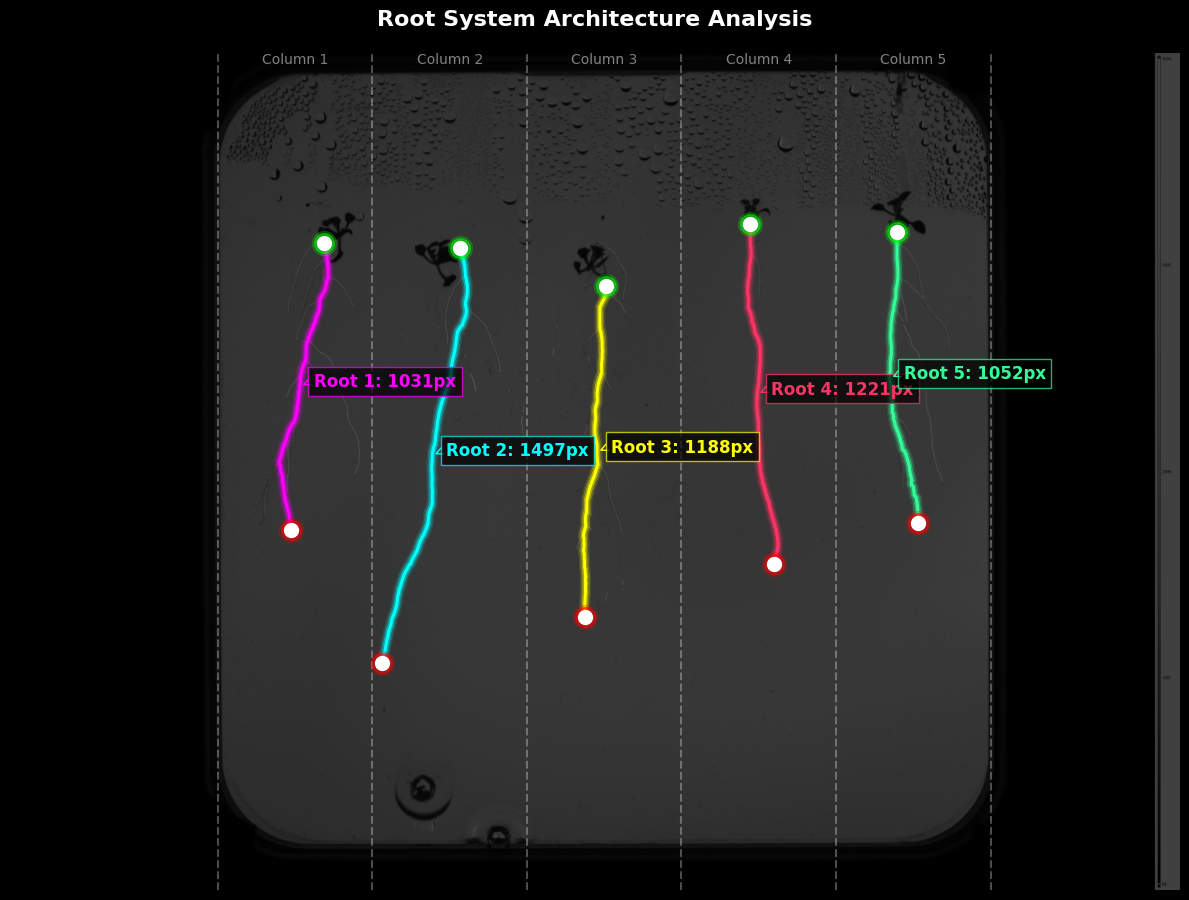


Root Tip Coordinates:
Column 1: (1007, 1714)
Column 2: (1335, 2195)
Column 3: (2066, 2027)
Column 4: (2744, 1835)
Column 5: (3262, 1689)


In [7]:
# Image path
image_path = glob.glob('./../task6/Kaggle/*.png')[1]

# Load the image
image = cv2.imread(image_path, 0)

# Get predictions
mask, overlay = inference.predict_roots(image_path, model)

# Initialize analyzer
analyzer = RootArchitectureAnalyzer()

# Process the mask and get root data, DataFrame, and tip coordinates
root_data, root_df, tip_coordinates = analyzer.process_image(mask, image)

# Visualize the roots with tip markers
analyzer.visualize_results(
    root_data=root_data,
    original_mask=mask,
    original_image=cv2.imread(image_path, 0)
)

# Print the tip coordinates
print("\nRoot Tip Coordinates:")
for tip in tip_coordinates:
    print(f"Column {tip['column']}: ({tip['tip_x']}, {tip['tip_y']})")

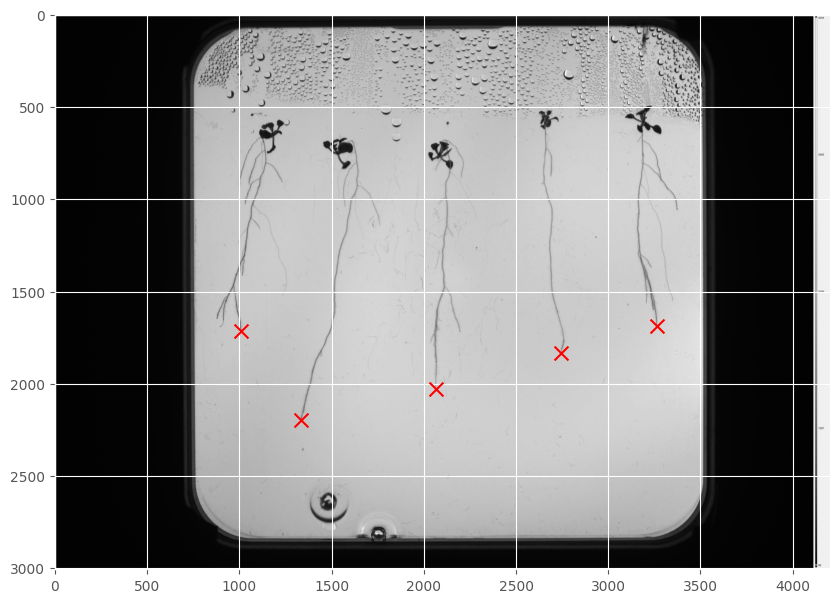

In [19]:
# Plot tip of the root
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
for tip in tip_coordinates:
    plt.scatter(tip['tip_x'], tip['tip_y'], c='red', marker='x', s=100)
plt.show()

In [21]:
# Display the DataFrame
print("\nRoot Analysis DataFrame:")
root_df


Root Analysis DataFrame:


,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance,has_root
0,1,0,1,1.000000,1,1.0,0.0,682,1129,683,1129,682,1129,683,1129,1.000000,True
1,1,1,2,1.000000,1,1.0,0.0,683,1129,684,1129,683,1129,684,1129,1.000000,True
2,1,2,3,1.000000,1,1.0,0.0,684,1129,685,1129,684,1129,685,1129,1.000000,True
3,1,3,4,1.000000,1,1.0,0.0,685,1129,686,1129,685,1129,686,1129,1.000000,True
4,1,4,5,1.000000,1,1.0,0.0,686,1129,687,1129,686,1129,687,1129,1.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5979,5,1046,1047,1.414214,1,1.0,0.0,1682,3262,1683,3261,1682,3262,1683,3261,1.414214,True
5980,5,1047,1048,1.000000,1,1.0,0.0,1683,3261,1684,3261,1683,3261,1684,3261,1.000000,True
5981,5,1048,1049,1.414214,1,1.0,0.0,1684,3261,1685,3262,1684,3261,1685,3262,1.414214,True
5982,5,1049,1050,1.000000,1,1.0,0.0,1685,3262,1686,3262,1685,3262,1686,3262,1.000000,True
